<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/VGG19_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive

mountdir = '/content/drive/'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + 'MyDrive'
w281_dir = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
inputdir = localdir + w281_dir
vggdir = inputdir + 'modeling/vgg_data/'

Mounted at /content/drive/


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, auc, roc_curve,
                             RocCurveDisplay, accuracy_score, make_scorer,)
from sklearn.model_selection import StratifiedKFold

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [13]:
import os
import cv2

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [37]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['banana' 'grapes' 'garlic' 'spinach' 'bell pepper' 'kiwi' 'cabbage'
 'chilli pepper' 'turnip' 'watermelon' 'pear' 'cauliflower' 'corn' 'apple'
 'mango' 'pomegranate' 'ginger' 'peas' 'pineapple' 'orange']


In [39]:
train = pd.read_csv(vggdir + 'vgg_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv(vggdir + 'vgg_test.csv').drop('Unnamed: 0', axis=1)
validation = pd.read_csv(vggdir + 'vgg_validation.csv').drop('Unnamed: 0', axis=1)

train['label'] = train_df['Label']
train = train.drop('0.1', axis=1)
validation['label'] = val_df['Label']
validation = validation.drop('0.1', axis=1)
test['label'] = test_df['Label']
test = test.drop('0.1', axis=1)

#### Bayesian Parameter Search

In [46]:
X_train, y_train = train.iloc[:, 0:-1], train.iloc[:, -1]
X_val, y_val = validation.iloc[:, 0:-1], validation.iloc[:, -1]
X_test, y_test = test.iloc[:, 0:-1], test.iloc[:, -1]


In [55]:
space = {
    # 'C' : hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))
    'C' : hp.uniform('C', 0.0001, 100),
    'solver' : hp.choice('solver', ['newton-cg','sag','saga','lbfgs']),
}

def optimize_lr(params):

    skf = StratifiedKFold(n_splits=3)
    clf = LogisticRegression(**params,
                             multi_class='ovr',
                             n_jobs=-1)
    f1_weighted = cross_val_score(clf, X_train, y_train,
                         scoring=make_scorer(accuracy_score),
                        cv=skf).mean()
    best_score = np.mean(f1_weighted)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}

In [56]:
RANDOM_SEED = 4321
trials = Trials()

best = fmin(
    fn=optimize_lr,
    space=space,
    algo=tpe.suggest,
    # algo=atpe.suggest,
    # algo=rand.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

100%|██████████| 100/100 [39:54<00:00, 23.94s/trial, best loss: 0.9357192881324221]
Best: {'C': 37.63347448025081, 'solver': 3}


#### Validation Inference

In [57]:
params = {'C': 37.63347448025081,
          'solver': 'lbfgs'
          }

lr_model0 = LogisticRegression(**params, n_jobs=-1)
lr_model0.fit(X_train, y_train)

y_pred = lr_model0.predict(X_val)
accuracy_score(y_val, y_pred)

0.06417112299465241

In [58]:
print(classification_report(y_val, y_pred))

               precision    recall  f1-score   support

        apple       0.00      0.00      0.00         9
       banana       0.00      0.00      0.00         9
  bell pepper       0.20      0.22      0.21         9
      cabbage       0.12      0.10      0.11        10
  cauliflower       0.00      0.00      0.00         9
chilli pepper       0.10      0.14      0.12         7
         corn       0.14      0.10      0.12        10
       garlic       0.00      0.00      0.00        10
       ginger       0.00      0.00      0.00        10
       grapes       0.11      0.12      0.12         8
         kiwi       0.10      0.10      0.10        10
        mango       0.10      0.10      0.10        10
       orange       0.00      0.00      0.00         7
         pear       0.11      0.10      0.11        10
         peas       0.11      0.11      0.11         9
    pineapple       0.00      0.00      0.00        10
  pomegranate       0.15      0.20      0.17        10
      spi

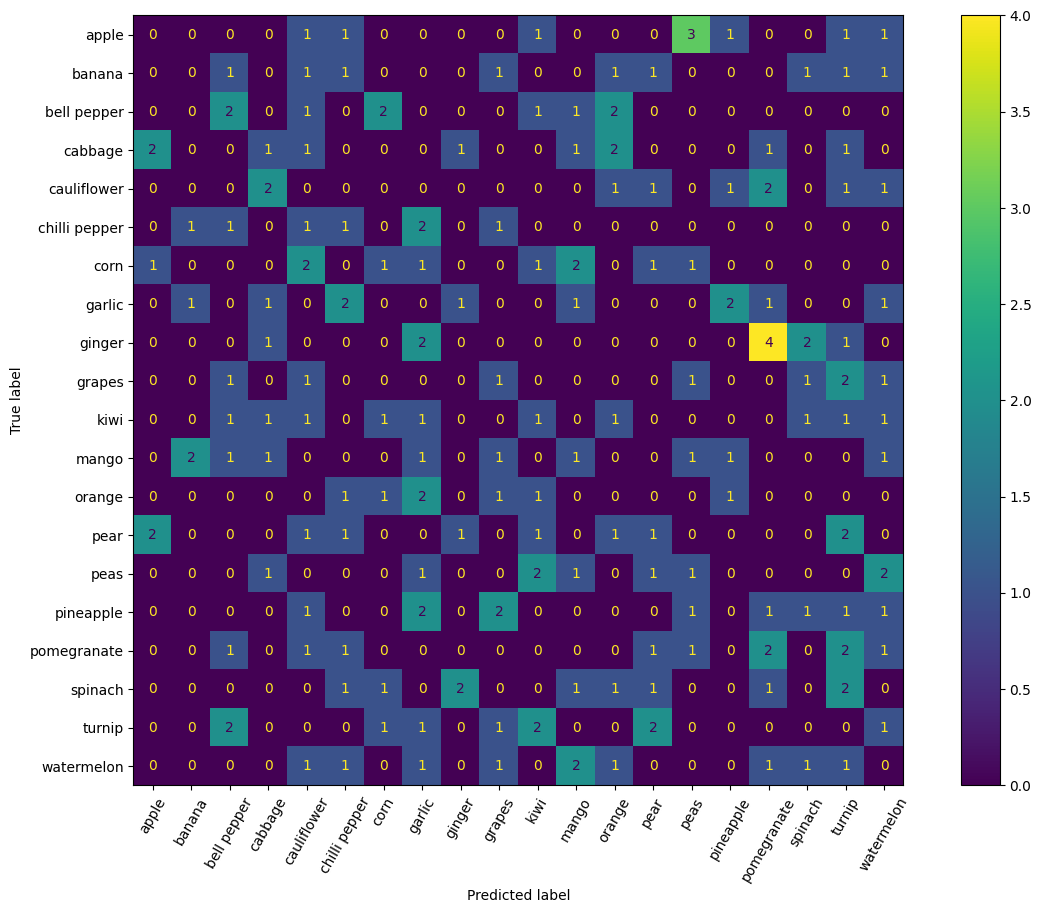

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, xticks_rotation=60, ax=ax)

#### Test Inference

In [65]:
params = {'C': 37.63347448025081,
          'solver': 'lbfgs'
          }

lr_model1 = LogisticRegression(**params, n_jobs=-1)
lr_model1.fit(X_train, y_train)

y_pred = lr_model1.predict(X_test)
accuracy_score(y_test, y_pred)

0.0427807486631016

In [61]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

        apple       0.00      0.00      0.00         9
       banana       0.00      0.00      0.00         9
  bell pepper       0.00      0.00      0.00         9
      cabbage       0.00      0.00      0.00        10
  cauliflower       0.15      0.22      0.18         9
chilli pepper       0.10      0.14      0.12         7
         corn       0.00      0.00      0.00        10
       garlic       0.00      0.00      0.00        10
       ginger       0.00      0.00      0.00        10
       grapes       0.00      0.00      0.00         8
         kiwi       0.10      0.10      0.10        10
        mango       0.00      0.00      0.00        10
       orange       0.10      0.14      0.12         7
         pear       0.00      0.00      0.00        10
         peas       0.11      0.11      0.11         9
    pineapple       0.00      0.00      0.00        10
  pomegranate       0.00      0.00      0.00        10
      spi

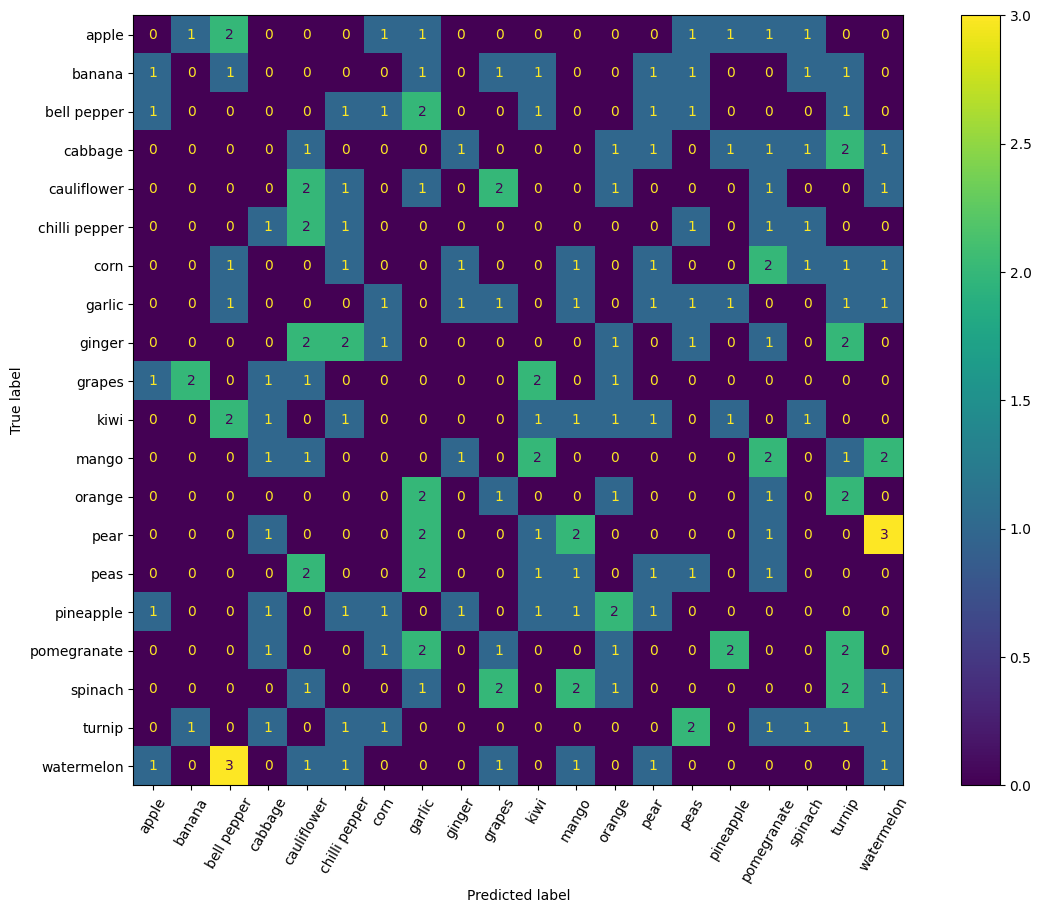

In [62]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=60, ax=ax)

## ROC Curve for Test Data

In [63]:
unique_training_labels = set([i for i in y_train.tolist()])
unique_val_labels = set([i for i in y_val.tolist()])
unique_test_labels = set([i for i in y_test.tolist()])

all_unique_labels = set(list(unique_training_labels) + list(unique_val_labels) + list(unique_test_labels))
all_unique_labels = sorted(list(all_unique_labels))
label_numeric_mapping = {k:v for v,k in enumerate(all_unique_labels)}

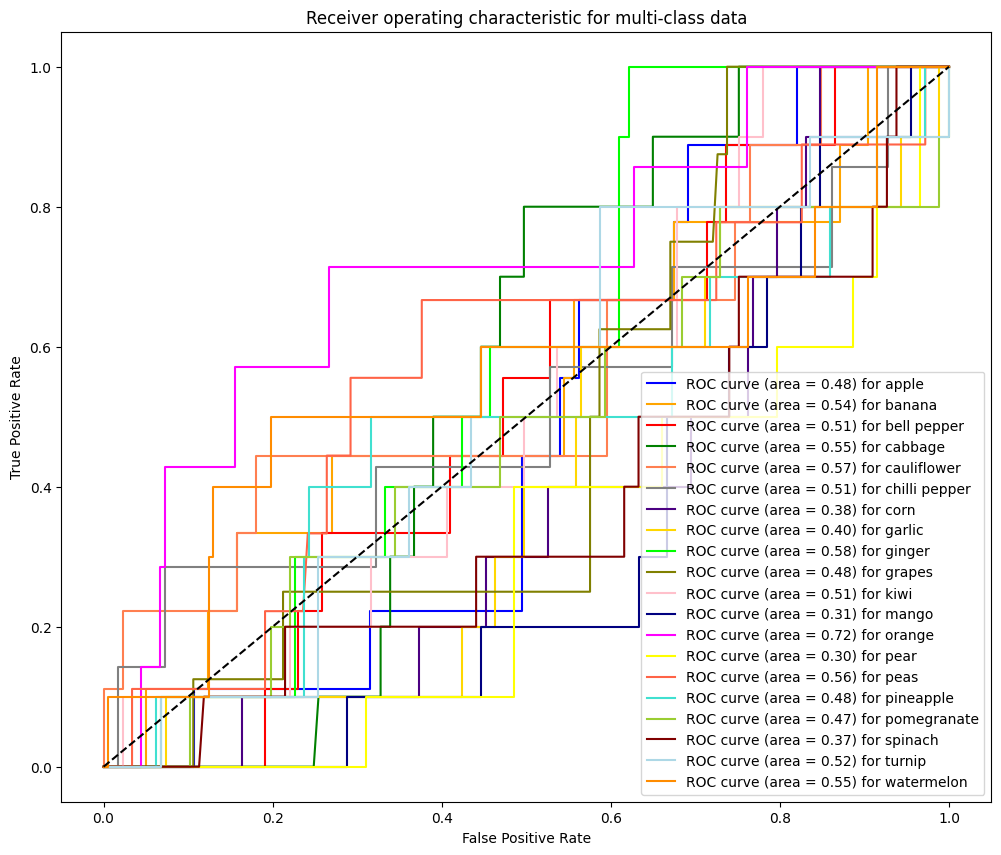

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

fig, ax = plt.subplots(figsize=(12,10))

color = ['blue', 'orange', 'red', 'green', 'coral',
          'grey', 'indigo', 'gold', 'lime', 'olive',
          'pink', 'navy', 'magenta', 'yellow', 'tomato',
          'turquoise', 'yellowgreen', 'maroon', 'lightblue', 'darkorange']

y_proba = lr_model1.predict_proba(X_test)

for class_id in range(0, len(all_unique_labels)):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    fpr, tpr, _ = roc_curve(y_onehot_test[:,class_id], y_proba[:,class_id])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color[class_id], label='ROC curve (area = %0.2f) for %s' % (roc_auc, all_unique_labels[class_id]))

plt.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic for SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()